# Fine-tuning an ONNX model with MXNet/Gluon

Fine-tuning is a common practice in Transfer Learning. One can take advantage of the pre-trained weights of a network, and use them as an initializer for their own task. Indeed, quite often it is difficult to gather a dataset large enough that it would allow training from scratch deep and complex networks such as ResNet152 or VGG16. For example in an image classification task, using a network trained on a large dataset like ImageNet gives a good base from which the weights can be slightly updated, or fine-tuned, to predict accurately the new classes. We will see in this tutorial that this can be achieved even with a relatively small number of new training examples.


[Open Neural Network Exchange (ONNX)](https://github.com/onnx/onnx) provides an open source format for AI models. It defines an extensible computation graph model, as well as definitions of built-in operators and standard data types.

In this tutorial we will:

- learn how to pick a specific layer from a pre-trained .onnx model file
- learn how to load this model in Gluon and fine-tune it on a different dataset

## Pre-requisite

To run the tutorial you will need to have installed the following python modules:
- [MXNet > 1.1.0](http://mxnet.incubator.apache.org/install/index.html)
- [onnx](https://github.com/onnx/onnx)
- matplotlib

We recommend that you have first followed this tutorial:
- [Inference using an ONNX model on MXNet Gluon](https://mxnet.incubator.apache.org/tutorials/onnx/inference_on_onnx_model.html)

In [1]:
import numpy as np
import mxnet as mx
from mxnet import gluon, nd, autograd
from mxnet.gluon.data.vision.datasets import ImageFolderDataset
from mxnet.gluon.data import DataLoader
import mxnet.contrib.onnx as onnx_mxnet
%matplotlib inline
import matplotlib.pyplot as plt
import tarfile, os
import json
import multiprocessing
import logging
logging.basicConfig(level=logging.INFO)

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Downloading supporting files
Import vizualisation script:

In [2]:
image_folder = "images"
utils_file = "utils.py" # contain utils function to plot nice visualization
images = ['wrench.jpg', 'dolphin.jpg', 'lotus.jpg']
base_url = "https://raw.githubusercontent.com/dmlc/web-data/master/mxnet/doc/tutorials/onnx/{}?raw=true"


for image in images:
    mx.test_utils.download(base_url.format("{}/{}".format(image_folder, image)), fname=image,dirname=image_folder)
mx.test_utils.download(base_url.format(utils_file), fname=utils_file)

from utils import *

INFO:root:images/wrench.jpg exists, skipping download
INFO:root:images/dolphin.jpg exists, skipping download
INFO:root:images/lotus.jpg exists, skipping download
INFO:root:utils.py exists, skipping download


## Downloading a model from the ONNX model zoo

We download a pre-trained model, in our case the [GoogleNet](https://arxiv.org/abs/1409.4842) model, trained on [ImageNet](http://www.image-net.org/) from the [ONNX model zoo](https://github.com/onnx/models). The model comes packaged in an archive `tar.gz` file containing an `model.onnx` model file.

### Dataset path

In [3]:
training_path = "/home/aiq/Dropbox/Eczema Images/flower_photos"
testing_path = "/home/aiq/Dropbox/Eczema Images/testing"

### Load the data using an ImageFolderDataset and a DataLoader

We need to transform the images to a format accepted by the network

In [4]:
EDGE = 299
SIZE = (EDGE, EDGE)
BATCH_SIZE = 16
NUM_WORKERS = multiprocessing.cpu_count()

We transform the dataset images using the following operations:
- resize the shorter edge to 224, the longer edge will be greater or equal to 224
- center and crop an area of size (224,224)
- transpose the channels to be (3,224,224)

In [5]:
def transform(image, label):
    resized = mx.image.resize_short(image, EDGE)
    cropped, crop_info = mx.image.center_crop(resized, SIZE)
    transposed = nd.transpose(cropped, (2,0,1))
    return transposed, label

The train and test dataset are created automatically by passing the root of each folder. The labels are built using the sub-folders names as label.
```
train_root
__label1
____image1
____image2
__label2
____image3
____image4
```

In [6]:
dataset_train = ImageFolderDataset(root=training_path, transform=transform)
dataset_test = ImageFolderDataset(root=testing_path, transform=transform)

We use num_workers=Number of CPU cores, which means the dataloading and pre-processing is going to be distributed across multiple processes. This will help preventing our GPU from starving and waiting for the data to be copied across

In [7]:
dataloader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, last_batch='discard',
                              shuffle=True, num_workers=NUM_WORKERS)
dataloader_test = DataLoader(dataset_test, batch_size=BATCH_SIZE, last_batch='discard',
                             shuffle=True, num_workers=NUM_WORKERS)
print("Train dataset: {} images, Test dataset: {} images".format(len(dataset_train), len(dataset_test)))

Train dataset: 1789 images, Test dataset: 80 images


In [8]:
categories = dataset_train.synsets
NUM_CLASSES = len(categories)
print(categories)

['acute', 'chronic', 'no eczema', 'subacute']


Let's plot the 1000th image to test the dataset

chronic


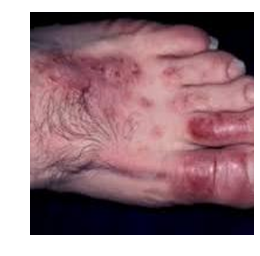

In [9]:
N = 1000
plt.imshow(np.transpose(dataset_train[N][0].asnumpy(),(1,2,0)))
plt.axis('off')
print(categories[dataset_train[N][1]])

## Fine-Tuning the MXNet model

### Getting the last layer

Load the MXNet model

In [10]:
def get_model(prefix, epoch, model_folder="model"):
    mx.test_utils.download(prefix+'-symbol.json', dirname=model_folder)
    mx.test_utils.download(prefix+'-%04d.params' % (epoch,), dirname=model_folder)

model_folder = "model"
get_model('http://data.dmlc.ml/models/imagenet/inception-bn/Inception-BN', 126, model_folder)
sym, arg_params, aux_params = mx.model.load_checkpoint('%s/Inception-BN' % model_folder, 126)

INFO:root:model/Inception-BN-symbol.json exists, skipping download
INFO:root:model/Inception-BN-0126.params exists, skipping download


In [11]:
#from mxnet.gluon.model_zoo import vision
#inception_v3 = vision.inception_v3(pretrained=True)

#sym, arg_params, aux_params = onnx_mxnet.import_model(onnx_path)

This function get the output of a given layer

In [12]:
def get_layer_output(symbol, arg_params, aux_params, layer_name):
    all_layers = symbol.get_internals()
    net = all_layers[layer_name+'_output']
    net = mx.symbol.Flatten(data=net)
    new_args = dict({k:arg_params[k] for k in arg_params if k in net.list_arguments()})
    new_aux = dict({k:aux_params[k] for k in aux_params if k in net.list_arguments()})
    return (net, new_args, new_aux)

Here we print the different layers of the network to make it easier to pick the right one

In [13]:
sym.get_internals()

<Symbol group [data, conv_1_weight, conv_1_bias, conv_1, bn_1_gamma, bn_1_beta, bn_1_moving_mean, bn_1_moving_var, bn_1, relu_1, pool_1, conv_2_red_weight, conv_2_red_bias, conv_2_red, bn_2_red_gamma, bn_2_red_beta, bn_2_red_moving_mean, bn_2_red_moving_var, bn_2_red, relu_2_red, conv_2_weight, conv_2_bias, conv_2, bn_2_gamma, bn_2_beta, bn_2_moving_mean, bn_2_moving_var, bn_2, relu_2, pool_2, conv_3a_1x1_weight, conv_3a_1x1_bias, conv_3a_1x1, bn_3a_1x1_gamma, bn_3a_1x1_beta, bn_3a_1x1_moving_mean, bn_3a_1x1_moving_var, bn_3a_1x1, relu_3a_1x1, conv_3a_3x3_reduce_weight, conv_3a_3x3_reduce_bias, conv_3a_3x3_reduce, bn_3a_3x3_reduce_gamma, bn_3a_3x3_reduce_beta, bn_3a_3x3_reduce_moving_mean, bn_3a_3x3_reduce_moving_var, bn_3a_3x3_reduce, relu_3a_3x3_reduce, conv_3a_3x3_weight, conv_3a_3x3_bias, conv_3a_3x3, bn_3a_3x3_gamma, bn_3a_3x3_beta, bn_3a_3x3_moving_mean, bn_3a_3x3_moving_var, bn_3a_3x3, relu_3a_3x3, conv_3a_double_3x3_reduce_weight, conv_3a_double_3x3_reduce_bias, conv_3a_double_

We can now visualize network (with graphviz installed)

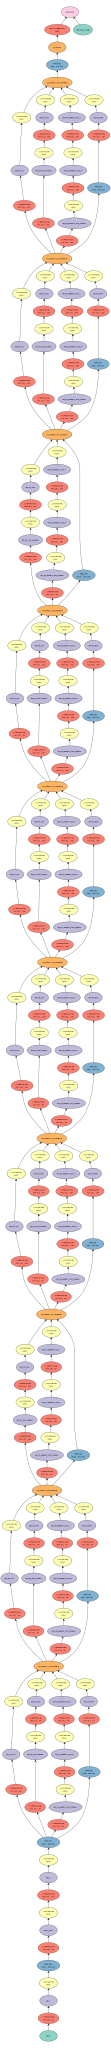

In [14]:
mx.viz.plot_network(sym, node_attrs={"shape":"oval","fixedsize":"false"})

We get the network until the output of the `flatten0` layer

In [15]:
new_sym, new_arg_params, new_aux_params = get_layer_output(sym, arg_params, aux_params, 'flatten')

### Fine-tuning in gluon


We can now take advantage of the features and pattern detection knowledge that our network learnt training on ImageNet, and apply that to the new Caltech101 dataset.


We pick a context, fine-tuning on CPU will be **WAY** slower.

In [16]:
ctx = mx.gpu() if mx.test_utils.list_gpus() else mx.cpu()

We create a symbol block that is going to hold all our pre-trained layers, and assign the weights of the different pre-trained layers to the newly created SymbolBlock

In [17]:
pre_trained = gluon.nn.SymbolBlock(outputs=new_sym, inputs=mx.sym.var('data'))
net_params = pre_trained.collect_params()
net_params.load(filename='%s/Inception-BN-0126.params' % model_folder, ignore_extra=True, ctx=ctx)
# for param in new_arg_params:
#     if param in net_params:
#         net_params[param]._load_init(new_arg_params[param], ctx=ctx)
# for param in new_aux_params:
#     if param in net_params:
#         net_params[param]._load_init(new_aux_params[param], ctx=ctx)

We create the new dense layer with the right new number of classes (101) and initialize the weights

In [18]:
dense_layer = gluon.nn.Dense(NUM_CLASSES)
dense_layer.initialize(mx.init.Xavier(magnitude=2.24), ctx=ctx)

We add the SymbolBlock and the new dense layer to a HybridSequential network

In [19]:
net = gluon.nn.HybridSequential()
net.add(pre_trained)
net.add(dense_layer)

In [20]:
net.hybridize()

### Loss
Softmax cross entropy for multi-class classification

In [21]:
softmax_cross_entropy = gluon.loss.SoftmaxCrossEntropyLoss()

### Trainer
Initialize trainer with common training parameters

In [22]:
LEARNING_RATE = 0.0005
WDECAY = 0.00001
MOMENTUM = 0.9

The trainer will retrain and fine-tune the entire network. If we use `dense_layer` instead of `net` in the cell below, the gradient updates would only be applied to the new last dense layer. Essentially we would be using the pre-trained network as a featurizer.

In [23]:
trainer = gluon.Trainer(net.collect_params(), 'sgd', 
                        {'learning_rate': LEARNING_RATE,
                         'wd':WDECAY,
                         'momentum':MOMENTUM})

### Evaluation loop

We measure the accuracy in a non-blocking way, using `nd.array` to take care of the parallelisation that MXNet and Gluon offers.

In [24]:
 def evaluate_accuracy_gluon(data_iterator, net):
    num_instance = nd.zeros(1, ctx=ctx)
    sum_metric = nd.zeros(1,ctx=ctx, dtype=np.int32)
    for i, (data, label) in enumerate(data_iterator):
        data = data.astype(np.float32).as_in_context(ctx)
        label = label.astype(np.int32).as_in_context(ctx)
        output = net(data)
        prediction = nd.argmax(output, axis=1).astype(np.int32)
        num_instance += len(prediction)
        sum_metric += (prediction==label).sum()
    accuracy = (sum_metric.astype(np.float32)/num_instance.astype(np.float32))
    return accuracy.asscalar()

In [25]:
%%time
print("Untrained network Test Accuracy: {0:.4f}".format(evaluate_accuracy_gluon(dataloader_test, net)))

Untrained network Test Accuracy: 0.2750
CPU times: user 380 ms, sys: 328 ms, total: 708 ms
Wall time: 1.26 s


### Training loop

In [26]:
num_epoch = 15
val_accuracy = 0
for epoch in range(num_epoch):
    for i, (data, label) in enumerate(dataloader_train):
        data = data.astype(np.float32).as_in_context(ctx)
        label = label.as_in_context(ctx)

        if i%20==0 and i >0:
            print('Batch [{0}] loss: {1:.4f}'.format(i, loss.mean().asscalar()))

        with autograd.record():
            output = net(data)
            loss = softmax_cross_entropy(output, label)
        loss.backward()
        trainer.step(data.shape[0])

    nd.waitall() # wait at the end of the epoch    
    new_val_accuracy = evaluate_accuracy_gluon(dataloader_test, net)
    print("Epoch [{0}] Test Accuracy {1:.4f} ".format(epoch, new_val_accuracy))


Batch [20] loss: 1.1291
Batch [40] loss: 0.7845
Batch [60] loss: 1.2348
Batch [80] loss: 0.9682
Batch [100] loss: 0.6100
Epoch [0] Test Accuracy 0.5375 
Batch [20] loss: 0.8817
Batch [40] loss: 0.4992
Batch [60] loss: 0.9521
Batch [80] loss: 0.5108
Batch [100] loss: 0.6852
Epoch [1] Test Accuracy 0.5125 
Batch [20] loss: 0.7279
Batch [40] loss: 0.4830
Batch [60] loss: 1.4816
Batch [80] loss: 0.6694
Batch [100] loss: 1.2655
Epoch [2] Test Accuracy 0.5875 
Batch [20] loss: 0.6288
Batch [40] loss: 0.4511
Batch [60] loss: 0.7152
Batch [80] loss: 0.3220
Batch [100] loss: 0.4550
Epoch [3] Test Accuracy 0.6500 
Batch [20] loss: 0.7863
Batch [40] loss: 0.4149
Batch [60] loss: 0.2547
Batch [80] loss: 0.9149
Batch [100] loss: 0.3963
Epoch [4] Test Accuracy 0.6750 
Batch [20] loss: 0.4288
Batch [40] loss: 0.3206
Batch [60] loss: 1.0053
Batch [80] loss: 0.3253
Batch [100] loss: 0.4437
Epoch [5] Test Accuracy 0.6625 
Batch [20] loss: 0.2913
Batch [40] loss: 0.3811
Batch [60] loss: 0.3683
Batch [80]

Adding a custom Softmax layer for output probability in testing.

In [27]:
# Kiem tra lai ham softmax, vi no da sai rui
class Softmax(gluon.HybridBlock):
    def __init__(self, **kwargs):
        super(Softmax, self).__init__(**kwargs)
        
    def hybrid_forward(self, F, x):
        return F.softmax(x)
    
net.add(Softmax())
net.hybridize()

## Testing
In the previous tutorial, we saw that the network trained on ImageNet couldn't classify correctly `wrench`, `dolphin`, `lotus` because these are not categories of the ImageNet dataset.

Let's see if our network fine-tuned on Caltech101 is up for the task:

In [28]:
# Number of predictions to show
TOP_P = 3

In [29]:
# Convert img to format expected by the network
def transform(img):
    return nd.array(np.expand_dims(np.transpose(img, (2,0,1)),axis=0).astype(np.float32), ctx=ctx)

In [30]:
# Load and transform the test images
import cv2
caltech101_images_test = [cv2.resize(cv2.imread(os.path.join(image_folder, "{}".format(img))), SIZE) for img in images]
caltech101_images_transformed = [transform(img) for img in caltech101_images_test]
#print caltech101_images_transformed

Helper function to run batches of data

In [31]:
def run_batch(net, data):
    results = []
    for batch in data:
        outputs = net(batch)
#         outputs = mx.nd.softmax(outputs)
        results.extend([o for o in outputs.asnumpy()])
    return np.array(results)

In [32]:
result = run_batch(net, caltech101_images_transformed)
print result

[[7.7982910e-04 2.1178821e-02 9.5845652e-01 1.9584876e-02]
 [7.4540779e-02 2.0367405e-01 4.4515161e-03 7.1733367e-01]
 [1.1200925e-02 3.4323564e-06 9.8872817e-01 6.7504472e-05]]


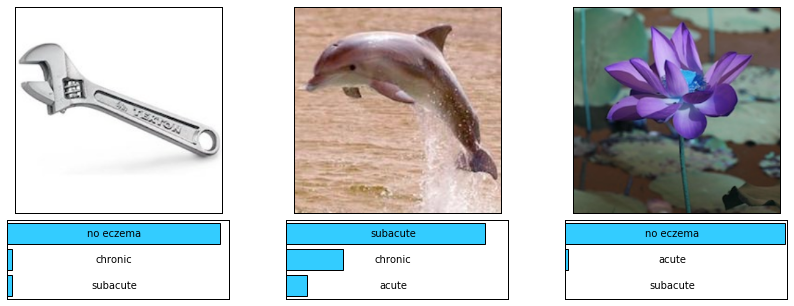

In [33]:
plot_predictions(caltech101_images_test, result, categories, TOP_P)

Let visualize some results from the test set.

[[9.6349150e-01 1.1790525e-03 2.6747026e-03 3.2654714e-02]
 [9.8207523e-04 1.6379539e-02 1.4178783e-06 9.8263699e-01]
 [1.8177696e-02 1.9171927e-02 7.6934139e-06 9.6264267e-01]]


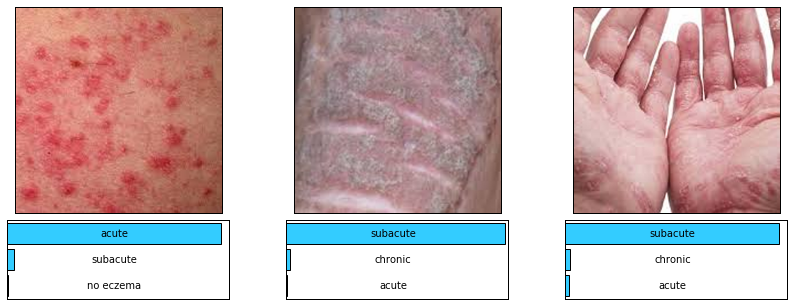

In [34]:
eczema_images_test = [dataset_test[np.random.randint(len(dataset_test))][0] for i in range(3)]
eczema_images_transformed = [nd.expand_dims(img, axis=0).astype(np.float32).as_in_context(ctx) for img in eczema_images_test]
result = run_batch(net, eczema_images_transformed)
# show the image
eczema_images = [np.transpose(img.asnumpy(), (1, 2, 0)) for img in eczema_images_test]
plot_predictions(eczema_images, result, categories, TOP_P)
print result

Save the model.

In [35]:
net.export('%s/eczema-inceptionv3' % model_folder, epoch=15)

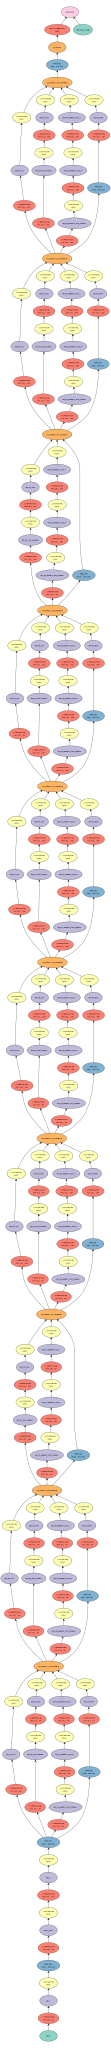

In [36]:
mx.viz.plot_network(sym, node_attrs={"shape":"oval","fixedsize":"false"})

In [37]:
net.summary

<bound method HybridSequential.summary of HybridSequential(
  (0): SymbolBlock(
  
  )
  (1): Dense(9216 -> 4, linear)
  (2): Softmax(
  
  )
)>